In [198]:
##Libraries to be imported 
import pandas as pd 
import numpy as np 
from sklearn.metrics import confusion_matrix,roc_auc_score, mean_squared_error,classification_report,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

In [199]:
##Data to be used
data = pd.read_csv('forModel.csv')
data.drop(['Checkup','Unnamed: 0.1','Unnamed: 0'], axis = 1, inplace =True)

##Cloned Data 
clonedData = pd.read_csv('forModel.csv')
clonedData['Heart_Disease'] = clonedData['Heart_Disease'].map({'Yes':1,'No':0})


### Model Preparation ! 
---

In [200]:
## lets first evaluate the datas that we will be using ! 

print(f"The data has {data.shape[0]} rows and {data.shape[1]} columns")
print(data.dtypes)

The data has 160000 rows and 19 columns
General_Health                   object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                     float64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption             float64
Fruit_Consumption               float64
Green_Vegetables_Consumption    float64
FriedPotato_Consumption         float64
SexBinary                         int64
dtype: object


---
### Feature Engineering 

In [201]:
## Lets convert few columns in order to create few 
##Lets use the One Hot Encoder to change all the categorical data into the numerical datatypes 
onlyCategorical = data.select_dtypes("object")
for everything in onlyCategorical.columns:
    print(f"The number of unique features that the columns {everything} has is {data[everything].nunique()}")


The number of unique features that the columns General_Health has is 5
The number of unique features that the columns Exercise has is 2
The number of unique features that the columns Heart_Disease has is 2
The number of unique features that the columns Skin_Cancer has is 2
The number of unique features that the columns Other_Cancer has is 2
The number of unique features that the columns Depression has is 2
The number of unique features that the columns Diabetes has is 4
The number of unique features that the columns Arthritis has is 2
The number of unique features that the columns Sex has is 2
The number of unique features that the columns Age_Category has is 13
The number of unique features that the columns Smoking_History has is 2


In [202]:
## As seen lets convert the binary category using the .map and nominal category using the onehotencoding 
data['General_Health'] = data['General_Health'].apply(lambda x: 'Poor' if x == 'Poor' else 'Good')
data['General_Health'] = data['General_Health'].map({"Poor":1, "Good":0})
data['Sex'] = data['Sex'].map({'Male':1, 'Female':0})
data['Diabetes'] = data['Diabetes'].apply(lambda x:'No' if x == 'No' else 'Yes')
## Since most of the Binary have Yes and No we will convert all of them at once 
cols = ['Exercise','Heart_Disease','Skin_Cancer','Other_Cancer','Depression','Arthritis','Smoking_History','Diabetes']
for each in cols:
    data[each] = data[each].map({'Yes':1,'No':0}) ##This converts the whole data into the binary 

dummiedData = pd.get_dummies(data, columns=['Age_Category'], dtype = 'int')


### The reason to convert the binary categories using the .map instead of using OneHotEncoding is to minimize the number of columns. 

### Lets build the Pipeline and compare between the two models: Logistic Regression and KNNeighborsClassifier 

In [203]:
## Dependent and Independent Variables 
y = clonedData['Heart_Disease'].values
X = dummiedData.drop('Heart_Disease', axis = 1).values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=32) ## Splitting the data 

---
### PipelineOne and its hyperparameter tuning

In [204]:
pipelineOne = Pipeline([
    ('imputer',SimpleImputer(strategy='median')), ##This is for the missing values
    ('scalar',StandardScaler()), ##This is to squeeze the data with the mean between 0 and 1 
    ('pca', PCA(n_components=0.95)), ## This is for the dimension reduction 
    ('logit',LogisticRegression(C=100)) ## This is the model that we will be working on ! 
]).fit(X_train,y_train)

In [205]:
pipelineOne.fit(X_train,y_train)
y_pred = pipelineOne.predict(X_test)


## Hyper parameter tunning 
param_grids = {
    'logit__C':[0.01,0.1,1,10,100]
}

bestValues = GridSearchCV(pipelineOne, param_grid= param_grids,cv = 5) ## Cross Val Score is set to 5
bestValues.fit(X_train,y_train)
print(bestValues.best_params_)  ##the value has been updated in the pipelineOne model 

{'logit__C': 100}


In [206]:
### Metrics of pipelineOne 
classificationReport = classification_report(y_pred,y_test)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.72      0.73      0.73     15776
           1       0.73      0.72      0.73     16224

    accuracy                           0.73     32000
   macro avg       0.73      0.73      0.73     32000
weighted avg       0.73      0.73      0.73     32000



In [207]:
### ROC Curve values 
#First lets get the predicted probabilites of the positive class
y_score = pipelineOne.predict_proba(X_test)[:,1]
tpr1,fpr1,thresholds1 = roc_curve(y_test,y_score) ## This are the ratio of the true positives and false positives 
aucScoreOne = roc_auc_score(y_test,y_score)


### In the Pipeline One we were able to have 72% precision, 73% recall and f1-Score of 73% after the hyperparameter tuning! 

---

### Pipeline Two and its hyperparameter tuning

In [208]:
pipelineTwo = Pipeline([
    ('imputer',SimpleImputer(strategy='median')), ##This is for the missing values
    ('scalar',StandardScaler()), ##This is to squeeze the data with the mean between 0 and 1 
    ('pca', PCA(n_components=0.95)), ## This is for the dimension reduction 
    ('knn',KNeighborsClassifier(n_neighbors = 3)) ## This is the model that we will be working on ! 
])

In [209]:
pipelineTwo.fit(X_train,y_train)
y_pred = pipelineTwo.predict(X_test)


## Hyper parameter tunning 
param_grids = {
    'knn__n_neighbors':[3,5,7,9]
}

bestValues = GridSearchCV(pipelineTwo, param_grid= param_grids,cv = 5) ## Cross Val Score is set to 5
bestValues.fit(X_train,y_train)
print(bestValues.best_params_)  ##the value has been updated in the pipelineTwo model

{'knn__n_neighbors': 3}


In [210]:
### Metrics of pipelineTwo 
classificationReport = classification_report(y_pred,y_test)
print(classificationReport)

              precision    recall  f1-score   support

           0       0.74      0.89      0.81     13394
           1       0.90      0.78      0.84     18606

    accuracy                           0.82     32000
   macro avg       0.82      0.83      0.82     32000
weighted avg       0.84      0.82      0.82     32000



In [211]:
### ROC Curve values 
#First lets get the predicted probabilites of the positive class
y_score2 = pipelineTwo.predict_proba(X_test)[:,1]
tpr2,fpr2,thresholds2 = roc_curve(y_test,y_score2) ## This are the ratio of the true positives and false positives 
aucScoreTwo = roc_auc_score(y_test,y_score2)

### In the Pipeline Two we were able to have 74% precision, 89% recall and f1-Score of 81% after the hyperparameter tuning! 

---
### Comparison between the two models

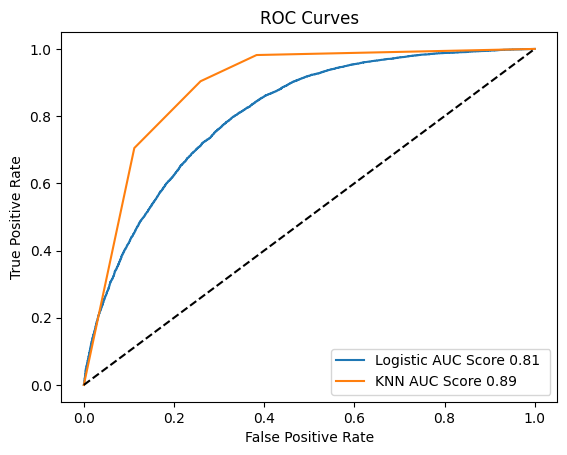

In [212]:
plt.plot(tpr1,fpr1,label = f'Logistic AUC Score {np.round(aucScoreOne,2)} ')
plt.plot(tpr2,fpr2,label = f'KNN AUC Score {np.round(aucScoreTwo,2)}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()